# Sentiment Based Product Recommendation System

In this notebook, we will build two types of Collaborative Filtering Recommendation system for given dataset
* User-User based Recommendation system
* Item-Item based Recommendation system

We will then evaluate both and pick the best

We will proceed to build sentiment analysis models using different algorithms such as Logistic Regression, Random Forest, XGBoost etc. based on product reviews to increase efficiency of our recommendation system by providing top custom recommendations for each user.

The entire project has been deployed in Heroku. **The final project can be viewed here at this link: https://sbprs-demo-nv.herokuapp.com/**

You can also view the entire project here: https://github.com/noble-v09/sentiment-based-product-recommendation


### Pre-requistes:
* Please place the <u>sample30.csv</u> dataset under project folder path: **./data**
* The classification models are built on scikit-learn version==1.0.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_colwidth', None)

import string
import swifter
# from collections import Counter

##NLP Libraries
# import spacy
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

from wordcloud import WordCloud

import pickle
import os

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
## Model selection, Oversampling technique --> SMOTE, feature extraction --> TFIDF
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Exploration

In [3]:
## Read csv file
df = pd.read_csv('./data/sample30.csv')

df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [4]:
## Dropping duplicates
df.drop_duplicates(inplace=True)

In [5]:
## Checking df properties - columns, dtypes, NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

From above its evident that ```user_sentiment``` column has one missing value. This column is import from a classsification point of view.

Lets check the review_text for further analysis

In [6]:
df[df['user_sentiment'].isnull()]['reviews_text'][28354]

'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

In [7]:
### Review content seems more Positive oriented so replace NaN with 'Positive' sentiment

df.loc[df['user_sentiment'].isnull(), 'user_sentiment'] = 'Positive'

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        30000 non-null  object
dtypes: int64(1), object(14)
memory usage

There are many columns which contains NULL values. However from model perspective, we only need few columns as follows:

```Recommendation system```: 'reviews_username', 'name', 'reviews_rating'

```Classification Models```: 'reviews_text', 'user_sentiment'

# Recommendation System

For recommendation system, we need to only worry about ratings, users and products(name)

In [9]:
## For recommendation system, we need to only worry about 
## ratings, users and products(name)
recommendation_df = df[['reviews_username', 'name', 'reviews_rating', 'categories']]

In [10]:
recommendation_df.rename(columns={'reviews_username': 'users', 'name': 'products', 'reviews_rating': 'ratings'}, inplace=True)

In [11]:
recommendation_df['ratings'].describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

Min ratings = 1

Max ratings = 5

In [12]:
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   users       29937 non-null  object
 1   products    30000 non-null  object
 2   ratings     30000 non-null  int64 
 3   categories  30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [13]:
round(recommendation_df.isnull().sum()/len(recommendation_df),5)

users         0.0021
products      0.0000
ratings       0.0000
categories    0.0000
dtype: float64

There are above 63 records with no usernames. This needs to be addressed. Either we go for imputation or deletion of these records

In [14]:
## Check the product count for NULL username

recommendation_df[recommendation_df['users'].isnull()]['products'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                         11
Clambake (dvd)                                                                                              3
Stander Pt Bedcane - Bed Handle                                                                             2
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural                         1
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    1
Vaseline I

Very limited number of count of products are present in NULL records. 

So, its best to delete such records as the null records are extremely low and imputation might lead to slightly biased results.

In [15]:
## Dropping NULL records

recommendation_df = recommendation_df[~recommendation_df['users'].isnull()]

In [16]:
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   users       29937 non-null  object
 1   products    29937 non-null  object
 2   ratings     29937 non-null  int64 
 3   categories  29937 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


Now we can proceed to splitting the dataset in to train-test set and build our Recommendation systems

In [17]:
## Split dataset
train, test = train_test_split(recommendation_df, train_size=0.75, random_state=42)

In [18]:
train.shape, test.shape

((22452, 4), (7485, 4))

In [19]:
## Keeping a dummy copy of train set for prediction
dummy_train = train.copy()

## Set the ratings of products as 1 for which user has not rated
dummy_train['ratings'] = dummy_train['ratings'].apply(lambda x: 0 if x>=1 else 1)

## create pivot table with ratings of products yet to be rated as 1 else 0
dummy_train = dummy_train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).fillna(1)

print(dummy_train.shape)

dummy_train.head()

(19431, 260)


products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## User-User based Collaborative Filtering

* First, we create user-item ratings pivot matrix
* Create a user-user correlation matrix
* Predict ratings for all products (rated or otherwise) by each user
* Finally we predict ratings of all those items for user that have not been rated, which is then passed on as recommendations

In [20]:
## Create user-product pivot
df_pivot = train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

df_pivot.head()

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_pivot.shape

(19431, 260)

###  User similarity matrix

We will be using Cosine Similarity to compute correlation matrix

Our data is a sparse matrix as majority of the products are not rated by user. There are quite few users who have only bought one product and rated as such. On taking Adjusted Cosine similarity - where we average out users ratings, users which have rated extremely low products, their averaged out ratings become zero. Hence to avoid that, we have used Cosine Similarity

In [22]:
from sklearn.metrics.pairwise import pairwise_distances

In [23]:
## Let normalize the ratings with mean around 0
## along each user
# mean = np.nanmean(df_pivot, axis=1)
# # mean

# df_subtracted = (df_pivot.T-mean).T
# df_subtracted.head()

## Lets compute user correlation using Cosine Similarity based on the products purchased and ratings given to them
# user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
## Compute similarity matrix
user_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')

## Substitute any NaN values to 0
user_correlation[np.isnan(user_correlation)] = 0

user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [24]:
user_correlation.shape

(19431, 19431)

In [25]:
## Setting negative correlations to 0 as we are only interested in users with some +ve correlation with other users
user_correlation[user_correlation<0] = 0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

### Prediction

Lets predict user ratings for non-rated products. 
* First, the predicted rating for the users (for rated as well as non-rated products) is the weighted sum of correlation with the product rating. Hence, we need to perform matrix multiplication for the two matrices ‘user_correlation’ and ‘df_pivot’ - which results in ratings for all products for every user
* Next we compute ratings of only those products that were not rated by each user - which are then recommended

In [26]:
## Get ratings for all the products (rated and non-rated)
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  2.8401134 ,  0.        , ..., 13.57603372,
         2.83621895,  1.49419593],
       [ 0.        , 24.41126271,  0.        , ..., 15.60499288,
         0.        ,  0.        ],
       [ 0.        , 24.41126271,  0.        , ..., 15.60499288,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  8.35058613,  0.        , ..., 11.37103222,
         3.07728727,  0.        ],
       [ 0.        ,  0.8256251 ,  0.        , ..., 11.70276753,
         2.98963727,  1.34164079],
       [ 0.        ,  8.35058613,  0.        , ..., 11.37103222,
         3.07728727,  0.        ]])

In [27]:
## Get ratings of all non rated products which can be passed on as recommendations
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,2.840113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.544828,...,1.988981,0.0,0.0,0.0,1.971150,0.0,0.0,13.576034,2.836219,1.494196
01impala,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02dakota,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02deuce,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
0325home,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
zxjki,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
zyiah4,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000


In [28]:
user_final_ratings.head()

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,2.840113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.544828,...,1.988981,0.0,0.0,0.0,1.971150,0.0,0.0,13.576034,2.836219,1.494196
01impala,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02dakota,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02deuce,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
0325home,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000


### Evaluation

Lets evaluate our recommendation system on test set
* First we create a pivot table with only common users in both train and test set
* Then, we reduce user-correlation matrix to only include common users
* Finally, we predict common users ratings' for all the products (rated/non-rated)
* Then, we only predict ratings for products that user has already rated and compute RMSE

In [29]:
## Extract common users
common = test[test['users'].isin(train['users'])]
common.head()

,users,products,ratings,categories
12875,jessica,Clorox Disinfecting Wipes Value Pack Scented 1...,5,"Household Essentials,Cleaning Supplies,Kitchen..."
22577,at527,Clear Scalp & Hair Therapy Total Care Nourishi...,4,"Personal Care,Hair Care,Shampoo,Featured Brand..."
21657,romance318,Nexxus Exxtra Gel Style Creation Sculptor,1,"Personal Care,Hair Care,Styling Gel/Lotion,Bea..."
23320,countprice,Godzilla 3d Includes Digital Copy Ultraviolet ...,3,"Movies, Music & Books,Movies,Action & Adventur..."
21505,farbar,Nexxus Exxtra Gel Style Creation Sculptor,1,"Personal Care,Hair Care,Styling Gel/Lotion,Bea..."


In [30]:
common.shape

(1799, 4)

In [31]:
## Create user-product pivot
common_user_based_matrix = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

In [32]:
common_user_based_matrix.shape

(1531, 129)

In [33]:
common_user_based_matrix.head()

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
## Lets convert user_correlation to a datframe with user list as index and columns
# user_correlation_df = pd.DataFrame(user_correlation, index=df_subtracted.index, columns=df_subtracted.index.to_list())

user_correlation_df = pd.DataFrame(user_correlation, index=df_pivot.index, columns=df_pivot.index.to_list())

user_correlation_df

,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
users,,,,,,,,,,,,,,,,,,,,,
00sab00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zxjki,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zyiah4,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [35]:
## Lets reduce the correlation df to only common users in train and test set
common_users_list = common['users'].to_list()
# len(common_users_list)

user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(common_users_list)]
user_correlation_df_1 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(common_users_list)]

user_correlation_df_1[user_correlation_df_1<0] = 0
user_correlation_df_1.shape

(1531, 1531)

In [36]:
user_correlation_df_1.head()

users,1234,1234567,123charlie,1witch,85lisa,a hutch,aac06002,aalyah,aaron,abcgator,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
1234,1.000000,0.0,0.662266,0.0,0.0,0.0,0.0,0.0,0.611775,0.0,...,0.330972,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.374634,0.0
1234567,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0
123charlie,0.662266,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1witch,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
85lisa,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0


In [37]:
## Get the predictions for all products(rated as well as non rated) in test set
common_user_predicted_ratings = np.dot(user_correlation_df_1, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[5.80295304, 3.78496941, 0.        , ..., 1.22144127, 0.        ,
        7.79183531],
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.88675135, 0.        , ..., 0.        , 0.        ,
        1.31227896],
       ...,
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.86700847],
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ]])

In [38]:
## Let get the ratings from the common set for products that are rated
dummy_test = common.copy()

## Set products to 1 if already rated else 0
dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

## create pivot
dummy_test = dummy_test.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).fillna(0)

dummy_test.head()

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
dummy_test.shape

(1531, 129)

In [40]:
## Compute ratings of only rated products
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)
common_user_predicted_ratings

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zebras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets compute RMSE to evaluate how close the predictions
* First we scale the predicted ratings using MinMaxScaler
* Compute the total number of products that were rated - non NaN values in pivot table
* Basically compute summation of (actual - Predictions)^2 divided by the total number of products that were rated
* Finally take the root

In [41]:
## First we scale the predicted ratings using MinMaxScaler between 1-5
from sklearn.preprocessing import MinMaxScaler

X = common_user_predicted_ratings.copy()
X = X[X>0]

sc = MinMaxScaler(feature_range=(1,5))
y = sc.fit_transform(X)

# y[0:5]

In [42]:
## Compute the total number of products that were rated - non NaN values in pivot table
total_non_nan_count = np.count_nonzero(~np.isnan(y))
total_non_nan_count

1744

In [43]:
common_ = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

## Compute rmse
rmse = (np.sum(np.sum((common_ - y)**2))/total_non_nan_count)**0.5
rmse

2.084841852467448

RMSE score = 2.08

Its quite low --> meaning our predictions are quite close to the actuals

In [44]:
## Lets see some of the recommendations for a user by our user-user based system
user = 'joshua'

## get top 20 recommendations
recommendations_op = user_final_ratings.loc[user].sort_values(ascending=False)[0:20]

pd.merge(recommendations_op, recommendation_df[['products', 'categories']].drop_duplicates(subset=None), on='products', how='left').rename(columns={
    user: 'predicted_ratings'
})

,products,predicted_ratings,categories
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,41.031789,"Movies, Music & Books,Movies,Action & Adventur..."
1,Mike Dave Need Wedding Dates (dvd + Digital),21.542676,"Movies & TV Shows,Movies,Romance,Romantic Come..."
2,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,14.116220,"Movies, Music & Books,Movies,Comedy,Movies & T..."
3,Planes: Fire Rescue (2 Discs) (includes Digita...,13.020465,"Movies, Music & Books,Movies,Kids' & Family,Wa..."
4,The Resident Evil Collection 5 Discs (blu-Ray),11.417684,"Movies, Music & Books,Ways To Shop Entertainme..."
5,Tostitos Bite Size Tortilla Chips,7.311154,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo..."
6,"Hormel Chili, No Beans",5.860649,"Food,Packaged Foods,Canned Foods,Canned Meals,..."
7,Clorox Disinfecting Wipes Value Pack Scented 1...,5.411070,"Household Essentials,Cleaning Supplies,Kitchen..."
8,Clorox Disinfecting Bathroom Cleaner,5.327245,"Household Chemicals,Household Cleaners,Bath & ..."
9,Alex Cross (dvdvideo),5.103395,"Movies & TV Shows,Instawatch Movies By VUDU,In..."


In [45]:
## Lets check out the products this user has already rated
recommendation_df[recommendation_df['users']==user]

,users,products,ratings,categories
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1559,joshua,Dark Shadows (includes Digital Copy) (ultravio...,3,"Movies, Music & Books,Movies,Comedy,Movies & T..."
5616,joshua,Red (special Edition) (dvdvideo),4,"Movies & TV Shows,Instawatch Movies By VUDU,Sh..."
17859,joshua,Smead174 Recycled Letter Size Manila File Back...,5,"School & Office Supplies,Filing,Files,File Fol..."
22742,joshua,Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...,5,"Food,Packaged Foods,Snacks,Chips & Pretzels,Sn..."


On comparison of the products rated by user ('joshua' in this instance) and the recommendations by User-User based system:
* We see that user has rated few moviess that are quite similar to the movies recommended by the system as it is evident from categories of products
* Recommendations of certain food, snacks categories like Tortilla Chips with are quite similar to product 'Cheetos' already rated by the user.
* There are certain categories of products such Personal Care, Household items etc. recommended for the user that are rated by similar users of the current user's peer group


Clearly the model is giving accurate recommendations

### Item-Item based Collaborative Filtering

Lets check the Item-Item based filtering to check if the recommendations are better

* First we create a User-Item based Ratings matrix using pivot table
* Then, we create Item-Item similarity (correlation) matrix
* Predict ratings for all products (rated or otherwise)
* Finally we predict ratings of all those items for user that have not been rated

In [46]:
## Create Item-User pivot
df_pivot = train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

df_pivot.head()

users,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_pivot.shape

(260, 19431)

In [48]:
## Before we compute item_correlation matrix, lets average out the ratings around mean 0
## Note: Mean is computed across items instead of users

# mean = np.nanmean(df_pivot, axis=1)
# # len(mean)

# df_subtracted = (df_pivot.T-mean).T
# print(df_subtracted.head())

## Lets compute Item-correlation matrix using Cosine Similarity
# item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
## Compute similarity matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')

## Substitute NaN values to 0
item_correlation[np.isnan(item_correlation)] = 0

item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00229002, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00229002, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [49]:
## Ignoring negative correlations as we are only looking for users with +ve correlation

item_correlation[item_correlation<0] = 0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00229002, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00229002, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [50]:
item_correlation.shape

(260, 260)

In [51]:
## Lets compute predicted ratings for all products(rated/non-rated)

item_predicted_ratings = np.dot((df_pivot.fillna(0).T), item_correlation)
item_predicted_ratings

array([[0.        , 0.02312729, 0.        , ..., 0.05629205, 0.0167301 ,
        0.0222563 ],
       [0.        , 0.0638275 , 0.        , ..., 0.03021493, 0.        ,
        0.        ],
       [0.        , 0.10637917, 0.        , ..., 0.05035821, 0.        ,
        0.        ],
       ...,
       [0.        , 0.0243351 , 0.        , ..., 0.02103937, 0.01044702,
        0.        ],
       [0.        , 0.01485814, 0.        , ..., 0.07054811, 0.0278835 ,
        0.0334357 ],
       [0.        , 0.01946808, 0.        , ..., 0.0168315 , 0.00835762,
        0.        ]])

In [52]:
item_predicted_ratings.shape

(19431, 260)

In [53]:
## Lets compute predicted ratings for only non rated products

item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
item_final_ratings

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.023127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066628,...,0.090846,0.0,0.0,0.0,0.065347,0.0,0.0,0.056292,0.016730,0.022256
01impala,0.0,0.063828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038870,...,0.042801,0.0,0.0,0.0,0.022759,0.0,0.0,0.030215,0.000000,0.000000
02dakota,0.0,0.106379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064783,...,0.071336,0.0,0.0,0.0,0.037932,0.0,0.0,0.050358,0.000000,0.000000
02deuce,0.0,0.085103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051827,...,0.057068,0.0,0.0,0.0,0.030345,0.0,0.0,0.040287,0.000000,0.000000
0325home,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000
zxjki,0.0,0.009734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007841,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.008416,0.004179,0.000000
zyiah4,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000


### Evaluation

In [54]:
## Let generate common set between test and train as we can only evaluate for products common to both set
common = test[test['products'].isin(train['products'])]
common.shape

(7473, 4)

In [55]:
common_item_based_matrix = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

common_item_based_matrix.head()

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex Cross (dvdvideo),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"All,bran Complete Wheat Flakes, 18 Oz.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
common_item_based_matrix.shape

(187, 7003)

Lets reduce the item corellation matrix to include only common products

In [57]:
## Lets create the item corellation dataframe
# item_correlation_df = pd.DataFrame(item_correlation, index=df_subtracted.index, columns=df_subtracted.index.to_list())
item_correlation_df = pd.DataFrame(item_correlation, index=df_pivot.index, columns=df_pivot.index.to_list())

# item_correlation_df = pd.DataFrame(item_correlation)
# item_correlation_df['products'] = df_subtracted.index
# item_correlation_df['products'] = df_pivot.index
# item_correlation_df.set_index('products', inplace=True)
# item_correlation_df.columns = df_subtracted.index.to_list()
# item_correlation_df.columns = df_pivot.index.to_list()

item_correlation_df.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00229,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.156022,0.0


In [58]:
## Get common list of products
common_product_list = common['products'].to_list()

## Reducing correlation matrix to only common products
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(common_product_list)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_product_list)]
item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3[item_correlation_df_3<0] = 0

item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00229,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [59]:
## Generate ratings for all common products (rated/non rated)
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00687007, 0.01946808, ..., 0.10637917, 0.02516123,
        0.0243351 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07934686, 3.        , 0.0168315 , ..., 0.05035821, 0.03361923,
        0.02103937],
       [0.        , 0.        , 0.00835762, ..., 0.        , 0.        ,
        0.01044702],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [60]:
## Lets generate ratings for only those products that are rated
dummy_test = common.copy()

## Set ratings as 1 if ratings is present else 0
dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

## Create pivot
dummy_test = dummy_test.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T.fillna(0)

dummy_test.head()

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
dummy_test.shape

(187, 7003)

In [62]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
common_item_predicted_ratings

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets compute RMSE to evaluate how close the predictions
* First we scale the predicted ratings using MinMaxScaler
* Compute the total number of products that were rated - non NaN values in pivot table
* Basically compute summation of (actual - Predictions)^2 divided by the total number of products that were rated
* Finally take the root

In [63]:
## First we scale the predicted ratings using MinMaxScaler
X = common_item_predicted_ratings.copy()
X = X[X>0]

sc1 = MinMaxScaler(feature_range=(1,5))
y = sc1.fit_transform(X)

# y[0:5]

In [64]:
## Compute the total number of products that were rated - non NaN values in pivot table
total_non_nan_count = np.count_nonzero(~np.isnan(y))
total_non_nan_count

7304

In [65]:
common_ = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

## Compute rmse
rmse = (np.sum(np.sum((common_ - y)**2))/total_non_nan_count)**0.5
rmse

3.5821553015427603

RMSE score = 3.58

Though its low, but **higher than the user-user based recommendation system** which is performing better in with the test set

In [66]:
## Lets see some of the recommendations for a user by item-item based system
user = 'joshua'

## get top 20 recommendations
recommendations_op = item_final_ratings.loc[user].sort_values(ascending=False)[0:20]

pd.merge(recommendations_op, recommendation_df[['products', 'categories']].drop_duplicates(subset=None), on='products', how='left').rename(columns={
    user: 'predicted_ratings'
})

,products,predicted_ratings,categories
0,Home Health Hairever Shampoo,0.398104,"Personal Care,Hair Care,Shampoo,Baby,Bathing,S..."
1,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.391763,"Personal Care,Hair Care,Conditioner,Beauty,Sha..."
2,Chips Ahoy! Original Chocolate Chip - Cookies ...,0.219158,"Food & Beverage,Cookies, Chips & Snacks,Cookie..."
3,Chobani174 Strawberry On The Bottom Non-Fat Gr...,0.200055,"Food & Beverage,Fresh Food,Dairy,Yogurt,Food &..."
4,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.186300,"Home,Home Appliances,Fireplaces & Accessories,..."
5,Mike Dave Need Wedding Dates (dvd + Digital),0.177652,"Movies & TV Shows,Movies,Romance,Romantic Come..."
6,Tostitos Bite Size Tortilla Chips,0.174166,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo..."
7,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.173148,"Movies, Music & Books,Movies,Comedy,Movies & T..."
8,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,0.160675,"Food & Beverage,Beverages,Soda & Pop,Grocery &..."
9,Olivella Bar Soap - 3.52 Oz,0.159782,"Personal Care,Bath, Shower & Soap,Bar Soap,Bat..."


In [67]:
## Lets check out the products this user has already rated
recommendation_df[recommendation_df['users']==user]

,users,products,ratings,categories
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1559,joshua,Dark Shadows (includes Digital Copy) (ultravio...,3,"Movies, Music & Books,Movies,Comedy,Movies & T..."
5616,joshua,Red (special Edition) (dvdvideo),4,"Movies & TV Shows,Instawatch Movies By VUDU,Sh..."
17859,joshua,Smead174 Recycled Letter Size Manila File Back...,5,"School & Office Supplies,Filing,Files,File Fol..."
22742,joshua,Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...,5,"Food,Packaged Foods,Snacks,Chips & Pretzels,Sn..."


On comparison of the products rated by user ('joshua' in this instance) and the recommendations by Item-Item based system:
* Recommendations of certain food, snacks categories like Chocolate Chip cookies with are quite similar to product 'Cheetos' already rated by the user.
* We see that user has rated few moviews that are quite similar to the movies recommended by the system as it is evident from categories of products
* There are certain categories of products such Personal Care, Household items etc. recommended for the user based on previously rated items

However, the recommendations don't seem to be as well refined as the ones recommended by User-User based system:
* As majority of ratings provided by current user is for movies which is what User based system is giving as top recommendations
* In addition to this, **RMSE score of User-User based system is quite lower than Item-Item based system**, making predictions more accurate

Hence, **User-User based Collaborative Filtering system seems to be the best in this case.** 

Lets save the recommendation system in pickle file

In [68]:
## Create folder path ==> ./models
if not os.path.exists('./models'):
    os.makedirs('./models')
    
## Save user-user based recommendations system
with open('./models/user_recommendations.pkl', 'wb') as f:
    pickle.dump(user_final_ratings, f)

# Sentiment based Text Classification

Lets proceed to classfication of reviews based on sentiments

Here, we are only concerned with following columns of dataset - 'reviews_text', 'user_sentiment'

In [69]:
classifier_df = df[['reviews_text', 'user_sentiment', 'reviews_title']]

## Resetting datatype of review_text and user_sentiment columns to string
classifier_df['reviews_text'] = classifier_df['reviews_text'].astype('str')
classifier_df['user_sentiment'] = classifier_df['user_sentiment'].astype('str')
classifier_df['reviews_title'] = classifier_df['reviews_title'].astype('str')

In [70]:
## Check class distribution
classifier_df['user_sentiment'].value_counts(normalize=True)

Positive    0.887767
Negative    0.112233
Name: user_sentiment, dtype: float64

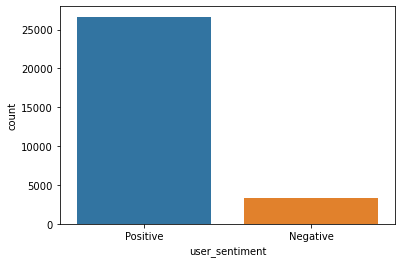

In [71]:
sns.countplot(data=classifier_df, x='user_sentiment')
plt.show()

Its quite evident from above plot that there is ```highly imbalanced``` class distribution in this dataset

In [72]:
## Combining Review titles and text together to get more words and check if it improves performance 
## -> Performance DO NOT IMPROVE but degrades so disabling the code
# classifier_df['reviews_text'] = classifier_df['reviews_title']+ ' ' + classifier_df['reviews_text']
# classifier_df.head(10)

## Text Preprocessing

In [73]:
## Before we proceed with model building, we need to clean the reviews text for better performance 

# spacy_sm = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# def lemmatize_text(x):
#     lemma_text_list = list() 
#     tokens = spacy_sm(x)
#     for token in tokens:
#         lemma_text_list.append(token.lemma_)
#     return ' '.join(lemma_text_list)

## Pre-processing
def preprocess_text(X):
    '''
    Convert into lowercase, remove digits or words containing digits, extra spaces, punctuations etc.
    '''
    ## Set to lowercase
    X = X.str.lower()
    
    ## Remove punctuations
    X = X.str.replace(f'[{string.punctuation}]', '', regex=True)
    
    ## Remove digits or words containing digits
    X = X.str.replace('\w*\d+\w*', '', regex=True)
    
    ## Remove extra spaces within content
    X = X.str.replace('\s\s+', ' ', regex=True)
    
    return X

lemmatizer = WordNetLemmatizer()

def get_wordnet_tag(tag):
    '''
    Get appropriate universal TAG of given word
    '''
    if tag.startswith('J'):
        return wordnet.ADJ ## Adjectives
    elif tag.startswith('N'):
        return wordnet.NOUN ## Nouns
    elif tag.startswith('R'):
        return wordnet.ADV ## Adverbs
    elif tag.startswith('V'):
        return wordnet.VERB ## Verbs
    else:
        return None

## Lemmatize text
def wordnet_lemmatize_text(x):
    '''
    Lemmatize text
    '''
    lemma_list = list()
    ## Get NLTK Treebank Tags
    tagged_list =  nltk.pos_tag(nltk.word_tokenize(x))
    ## Create a tuple of word and WordNet Tag
    wordnet_tagged_list = map(lambda x: (x[0], get_wordnet_tag(x[1])), tagged_list)
    for word, tag in wordnet_tagged_list:
        if tag:
            ## If tag exists then lemmatize
            lemma_list.append(lemmatizer.lemmatize(word, tag))
        else:
            lemma_list.append(word)
    return ' '.join(lemma_list)

# print(s, ' '.join(wordnet_lemmatize_text(s)), sep='\n')
classifier_df['reviews_text'] = preprocess_text(classifier_df['reviews_text'])
# classifier_df['spacy_lemma_reviews_text'] = classifier_df['reviews_text'].swifter.apply(lambda x: lemmatize_text(x))
classifier_df['lemma_reviews_text'] = classifier_df['reviews_text'].swifter.apply(lambda x: wordnet_lemmatize_text(x))

Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]

In [74]:
# classifier_df['spacy_lemma_reviews_text'][0]
# classifier_df['wordnet_lemma_reviews_text'][0]
classifier_df.head()

,reviews_text,user_sentiment,reviews_title,lemma_reviews_text
0,i love this album its very good more to the hi...,Positive,Just Awesome,i love this album its very good more to the hi...
1,good flavor this review was collected as part ...,Positive,Good,good flavor this review be collect as part of ...
2,good flavor,Positive,Good,good flavor
3,i read through the reviews on here before look...,Negative,Disappointed,i read through the review on here before look ...
4,my husband bought this gel for us the gel caus...,Negative,Irritation,my husband buy this gel for us the gel cause i...


In [75]:
classifier_df['reviews_text'][28354] ## original processed review text

'my kids absolutely loved this film so much that we watched it twice having a digital copy means that every time we get in the car we get to watch it wherever we go we even got to use our reward coupon towards the purchase of this movie so we got an additional off we got to add the points towards our next rewards coupon we love the savings we get at best buy'

In [76]:
classifier_df['lemma_reviews_text'][28354] ## lemmatized and processed review text

'my kid absolutely love this film so much that we watch it twice have a digital copy mean that every time we get in the car we get to watch it wherever we go we even get to use our reward coupon towards the purchase of this movie so we get an additional off we get to add the point towards our next reward coupon we love the saving we get at best buy'

## Text Exploration

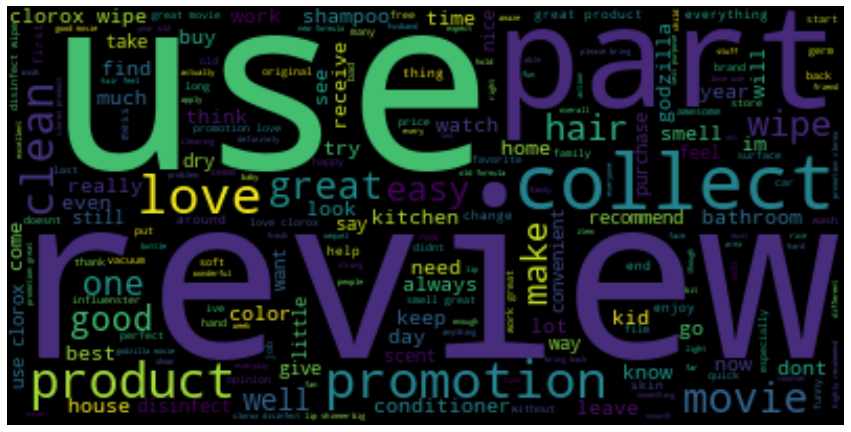

In [77]:
## Building word cloud to see some of the most frequently occuring words using Wordcloud

text = ' '.join(classifier_df['lemma_reviews_text'].tolist())
wordcloud = WordCloud().generate(text)

plt.figure(figsize=[15, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]

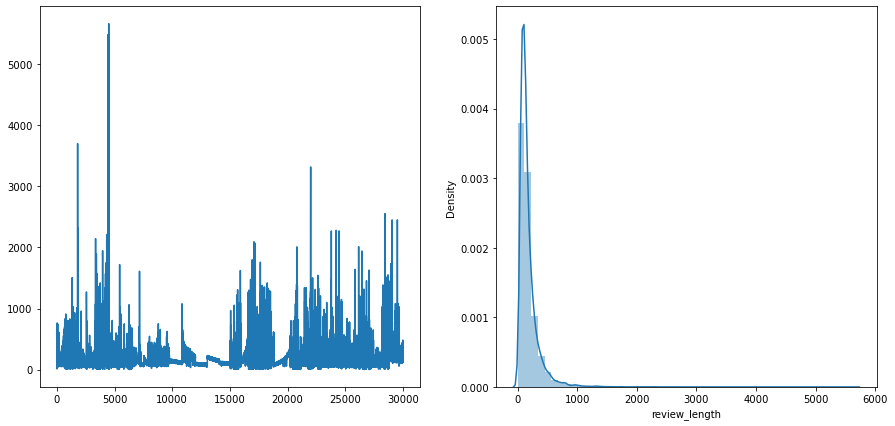

In [78]:
## Lets check length distributon of reviews in the dataset
classifier_df['review_length'] = classifier_df['reviews_text'].swifter.apply(lambda x: len(x))

## Plotting review length
plt.figure(figsize=[15,7])
plt.subplot(1,2,1)
plt.plot(classifier_df.index, classifier_df['review_length'])

plt.subplot(1,2,2)
sns.distplot(classifier_df['review_length'])
plt.show()

There are **reviews with more than 5000 characters** in the dataset

In [79]:
## Dropping unnecessary columns
classifier_df.drop(columns=['reviews_text', 'reviews_title', 'review_length'], inplace=True)

## Renaming lemma_reviews_text column to reviews_text
classifier_df.rename(columns={'lemma_reviews_text': 'reviews_text'}, inplace=True)

classifier_df.columns

Index(['user_sentiment', 'reviews_text'], dtype='object')

In [80]:
classifier_df.head()

,user_sentiment,reviews_text
0,Positive,i love this album its very good more to the hi...
1,Positive,good flavor this review be collect as part of ...
2,Positive,good flavor
3,Negative,i read through the review on here before look ...
4,Negative,my husband buy this gel for us the gel cause i...


## Feature Extraction
* Here we split data in train and test set
* Then we apply TFIDF Vectorizer to the train set and transform the test set
* To handle class imbalance, we will be looking at two different methods:
>* using class_weight attribute of each model
>* SMOTE

In [81]:
## Splitting data into train and test set
classifier_df_train, classifier_df_test = train_test_split(classifier_df, train_size=0.8, random_state=42)

In [82]:
classifier_df_train.shape, classifier_df_test.shape

((24000, 2), (6000, 2))

In [83]:
## Extracting text and target in both data set
X_train = classifier_df_train.drop(columns=['user_sentiment'])
y_train = classifier_df_train['user_sentiment']

X_test = classifier_df_test.drop(columns=['user_sentiment'])
y_test = classifier_df_test['user_sentiment']

In [84]:
X_train.head()

,reviews_text
21753,i have use this hair gel for many year and rec...
251,i love the way this awesome moisturizer immedi...
22941,i be expect something betterbetween the bug ba...
618,i slowly add product from the oil of olay rege...
17090,love this rice its a very tasty mix of several...


In [85]:
## Converting text to tfidf features
tfidf_model = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=0.005, ngram_range=(1, 3), sublinear_tf=True)
# tfidf_model = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=0.002, ngram_range=(1, 3), sublinear_tf=True)
tfidf_vectors = tfidf_model.fit_transform(X_train['reviews_text'])

# print(tfidf_model.get_feature_names())
print(len(tfidf_model.get_feature_names()))

580


In [86]:
## Set train set features
X_train_tfidf = pd.DataFrame(data=tfidf_vectors.toarray(), columns=tfidf_model.get_feature_names())

## Set test set features - use tfidf.transform to fit with same vocabulary used for training
X_test_tfidf = pd.DataFrame(data=tfidf_model.transform(X_test['reviews_text']).toarray(), columns=tfidf_model.get_feature_names())

In [87]:
y_train.value_counts()

Positive    21284
Negative     2716
Name: user_sentiment, dtype: int64

In [88]:
## Lets create tfidf features using SMOTE to address Class imbalance and keep it handy for model building

smote = SMOTE()

X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

## Check if both classes have same number of samples
y_train_smote.value_counts()

Negative    21284
Positive    21284
Name: user_sentiment, dtype: int64

Both classes have equal number of samples after application of SMOTE

In [89]:
## Setting class labels --> Negative=0; Positive=1

y_train = np.where(y_train=='Negative',0,1)
y_train_smote = np.where(y_train_smote=='Negative',0,1)
y_test = np.where(y_test=='Negative',0,1)

## Model Building

In [90]:
## Import modules for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [91]:
## Create a dataframe to contain all models performance with regards to test set for final comparison

test_metrics = pd.DataFrame(columns=['Model', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])

## Append each model test performance using this function
def set_test_metrics(model, y_true, y_pred):
    metric = list()
    metric.extend([
        model,
        roc_auc_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        accuracy_score(y_true, y_pred)
    ])
    metric = pd.Series(metric, index= test_metrics.columns)
    return metric    

### Logistic Regression

**Lets build LR model with class_weight attribute to address Class Imbalance instead of SMOTE**

In [92]:
## Base estimator
lr_base = LogisticRegression(random_state=42, solver='saga', class_weight='balanced')

## cross validation folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hyper-paramters
params = {
    'max_iter': [100, 200, 300],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

## Instantiate gridsearchcv
grid_search_lr = GridSearchCV(
    estimator=lr_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit models
grid_search_lr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=2)

In [93]:
## Check top 5 cross validation results
cv_res_lr = pd.DataFrame(grid_search_lr.cv_results_)
cv_res_lr.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
37,15.714893,0.035079,0.004529,0.006178,1000,100,l2,"{'C': 1000, 'max_iter': 100, 'penalty': 'l2'}",0.908033,0.950299,...,0.925773,0.014002,1,0.909126,0.955982,0.939486,0.931746,0.933057,0.933879,0.015086
22,61.808112,0.308523,0.015168,0.001888,1,300,l1,"{'C': 1, 'max_iter': 300, 'penalty': 'l1'}",0.943588,0.934296,...,0.922259,0.014761,2,0.943146,0.943512,0.913149,0.919720,0.920015,0.927909,0.012829
30,24.931914,0.178510,0.020054,0.006589,100,100,l1,"{'C': 100, 'max_iter': 100, 'penalty': 'l1'}",0.906697,0.949141,...,0.920899,0.022921,3,0.907826,0.956481,0.951320,0.899336,0.926471,0.928287,0.022740
29,47.359245,0.286888,0.018810,0.006367,10,300,l2,"{'C': 10, 'max_iter': 300, 'penalty': 'l2'}",0.926714,0.914422,...,0.918316,0.004553,4,0.924261,0.927626,0.926255,0.926922,0.925603,0.926133,0.001153
27,32.510011,0.553227,0.006630,0.007520,10,200,l2,"{'C': 10, 'max_iter': 200, 'penalty': 'l2'}",0.926313,0.914536,...,0.918313,0.004449,5,0.924367,0.927273,0.926044,0.926645,0.925872,0.926040,0.000971


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - Logistic Regression)

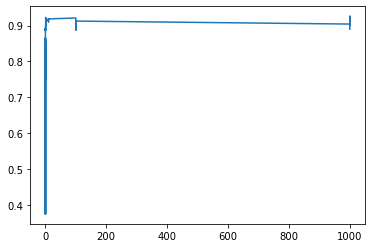

In [94]:
plt.plot(cv_res_lr['param_C'], cv_res_lr['mean_test_score'])
plt.show()

In [95]:
## Get best estimator
lr_best = grid_search_lr.best_estimator_
lr_best

LogisticRegression(C=1000, class_weight='balanced', random_state=42,
                   solver='saga')

In [96]:
## Evaluation
y_train_pred = lr_best.predict(X_train_tfidf)
y_test_pred = lr_best.predict(X_test_tfidf)

In [97]:
## Performance Check on train and test set

print('Train set \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set 
               precision    recall  f1-score   support

           0       0.49      0.88      0.63      2716
           1       0.98      0.88      0.93     21284

    accuracy                           0.88     24000
   macro avg       0.74      0.88      0.78     24000
weighted avg       0.93      0.88      0.90     24000


AUC Score 0.880009744090647
****************************************************************************************************
Test set 
               precision    recall  f1-score   support

           0       0.47      0.83      0.60       651
           1       0.98      0.89      0.93      5349

    accuracy                           0.88      6000
   macro avg       0.72      0.86      0.77      6000
weighted avg       0.92      0.88      0.89      6000


AUC Score 0.8581939171196131


From the current Logistic Regression model's classification report:
* In the test set, overall F1 score is decent; however just for the negative samples it seems the score is low; precision score is quite low as well
* Other metric scores such as AUC, Accuracy etc.are also good enough

Lets see if we can improve the models performance using SMOTE

In [98]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('Logistic Regression (Class Weight)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667


**Lets try rebuilding LR model using SMOTE technique**

In [99]:
## Set estimator
lr_base = LogisticRegression(random_state=42, solver='saga')

## Cv folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

## Hyper-parameters
params = {
    'max_iter': [100, 200, 300],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

## Instantiate GridSearchCV
grid_search_lr_smote = GridSearchCV(
    estimator=lr_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit models
grid_search_lr_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=2)

In [100]:
## Check top 5 cross validation results
cv_res_lr_smote = pd.DataFrame(grid_search_lr_smote.cv_results_)
cv_res_lr_smote.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
33,58.452233,0.787289,0.040629,0.015942,100,200,l2,"{'C': 100, 'max_iter': 200, 'penalty': 'l2'}",0.918181,0.917284,...,0.917855,0.001802,1,0.924729,0.924949,0.924930,0.925511,0.924809,0.924985,0.000275
35,83.131417,1.504752,0.028215,0.018378,100,300,l2,"{'C': 100, 'max_iter': 300, 'penalty': 'l2'}",0.918181,0.917284,...,0.917855,0.001802,1,0.924701,0.924949,0.924963,0.925511,0.924809,0.924986,0.000279
31,29.443009,0.319407,0.026002,0.013220,100,100,l2,"{'C': 100, 'max_iter': 100, 'penalty': 'l2'}",0.918181,0.916910,...,0.917754,0.001710,3,0.924696,0.924976,0.924903,0.925483,0.924776,0.924967,0.000276
25,14.066236,0.430828,0.027026,0.009725,10,100,l2,"{'C': 10, 'max_iter': 100, 'penalty': 'l2'}",0.918450,0.916849,...,0.917743,0.001563,4,0.923936,0.924890,0.924380,0.925545,0.924122,0.924574,0.000582
27,13.513155,0.339644,0.022665,0.007119,10,200,l2,"{'C': 10, 'max_iter': 200, 'penalty': 'l2'}",0.918450,0.916849,...,0.917743,0.001563,4,0.923936,0.924890,0.924380,0.925545,0.924122,0.924574,0.000582


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - Logistic Regression)

In [101]:
## Get best estimator
lr_smote_best = grid_search_lr_smote.best_estimator_
lr_smote_best

LogisticRegression(C=100, max_iter=200, random_state=42, solver='saga')

In [102]:
## Evaluation
y_train_pred = lr_smote_best.predict(X_train_tfidf_smote)
y_test_pred = lr_smote_best.predict(X_test_tfidf)

In [103]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93     21284
           1       0.94      0.91      0.92     21284

    accuracy                           0.93     42568
   macro avg       0.93      0.93      0.93     42568
weighted avg       0.93      0.93      0.93     42568


AUC Score 0.9256013907160308
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.51      0.82      0.63       651
           1       0.98      0.90      0.94      5349

    accuracy                           0.90      6000
   macro avg       0.74      0.86      0.78      6000
weighted avg       0.93      0.90      0.91      6000


AUC Score 0.8610231638111435


From the current Logistic Regression (SMOTE) model's classification report:
* In the test set, overall F1 score has improved significantly; just for the negative samples --> precision and F1 score has increased in comparison to previous model 
* Other metric scores such as AUC, Accuracy etc. have improved

Lets try other models such as Random Forest, XGBoost etc. and see if we can get better results

In [104]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('Logistic Regression (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333


### Random Forest

**Lets build Random Forest ensemble with class_weight attribute to address Class Imbalance instead of SMOTE**

In [105]:
## Set estimator
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

## folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## hyper-parameters
params = {
    'max_depth': [3,5,10,15,20],
    'n_estimators': [50,100,150,200],
    'min_samples_split': [200, 250, 300],
    'min_samples_leaf': [100, 150, 200]
}

## Instantiate GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit model
grid_search_rf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='f1', verbose=2)

In [106]:
## Check top 5 cross validation results
cv_res_rf = pd.DataFrame(grid_search_rf.cv_results_)
cv_res_rf.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
147,44.998603,0.387471,0.656434,0.018604,20,100,200,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.892484,...,0.889352,0.004832,1,0.893319,0.890933,0.891530,0.889473,0.892560,0.891563,0.001330
151,44.670013,0.391560,0.662971,0.011999,20,100,250,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.892088,...,0.889280,0.004655,2,0.893179,0.890940,0.891941,0.889038,0.892340,0.891488,0.001421
155,44.742805,0.346880,0.684989,0.050316,20,100,300,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.891496,...,0.889268,0.004733,3,0.892665,0.890954,0.891940,0.889906,0.892418,0.891577,0.001020
146,33.605528,0.311749,0.543428,0.038218,20,100,200,150,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.891637,...,0.888669,0.004701,4,0.891116,0.891295,0.889778,0.888932,0.890523,0.890329,0.000877
154,33.351452,0.302589,0.521575,0.043575,20,100,300,150,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.889457,...,0.888109,0.004555,5,0.889521,0.891111,0.890027,0.888540,0.890061,0.889852,0.000835


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - Random Forest)

In [107]:
## Get best estimator
rf_best = grid_search_rf.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=100, min_samples_split=200,
                       n_estimators=200, random_state=42)

In [108]:
## Evaluation
y_train_pred = rf_best.predict(X_train_tfidf)
y_test_pred = rf_best.predict(X_test_tfidf)

In [109]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.38      0.86      0.52      2716
           1       0.98      0.82      0.89     21284

    accuracy                           0.82     24000
   macro avg       0.68      0.84      0.71     24000
weighted avg       0.91      0.82      0.85     24000


AUC Score 0.8380924402961673
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.37      0.83      0.51       651
           1       0.98      0.83      0.89      5349

    accuracy                           0.83      6000
   macro avg       0.67      0.83      0.70      6000
weighted avg       0.91      0.83      0.85      6000


AUC Score 0.8280216035901452


From the current Random Forest model's classification report:
* In the test set, overall F1 and other metric scores such as precision are quite low, especially for negative samples; much lower than Logistic regression (SMOTE) model. AUC score is also low

Lets see if we can improve the model's performance using SMOTE applied  train set

In [110]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('Random Forest (Class Weight)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667


**Lets build Random Forest ensemble using SMOTE**

In [111]:
## Set estimator
rf_base = RandomForestClassifier(random_state=42)

## folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

## hyper-parameters
params = {
    'max_depth': [3,5,10,15,20],
    'n_estimators': [50,100,150,200],
    'min_samples_split': [200, 250, 300],
    'min_samples_leaf': [100, 150, 200]
}

## Instantiate GridSearchCV
grid_search_rf_smote = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit model
grid_search_rf_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='f1', verbose=2)

In [112]:
## Check top 5 cross validation results
cv_res_rf_smote = pd.DataFrame(grid_search_rf_smote.cv_results_)
cv_res_rf_smote.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
151,21.113247,0.140044,0.241964,0.007633,20,100,250,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.859514,...,0.858825,0.001598,1,0.863078,0.859236,0.860380,0.863996,0.861900,0.861718,0.001733
155,20.813522,0.077464,0.235071,0.001690,20,100,300,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.860327,...,0.858780,0.002019,2,0.863601,0.860150,0.859577,0.863243,0.862189,0.861752,0.001620
147,21.288750,0.133286,0.230004,0.008358,20,100,200,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.861039,...,0.858745,0.002001,3,0.863753,0.859118,0.859979,0.863353,0.862086,0.861658,0.001828
145,10.679302,0.068601,0.136408,0.006472,20,100,200,100,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.858329,...,0.857734,0.002095,4,0.861829,0.859889,0.858579,0.859820,0.861947,0.860413,0.001292
149,10.720895,0.087538,0.140676,0.010123,20,100,250,100,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.856973,...,0.857518,0.001970,5,0.860944,0.859411,0.858431,0.861055,0.861631,0.860295,0.001186


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - Random Forest)

In [113]:
## Get best estimator
rf_smote_best = grid_search_rf_smote.best_estimator_
rf_smote_best

RandomForestClassifier(max_depth=20, min_samples_leaf=100,
                       min_samples_split=250, n_estimators=200,
                       random_state=42)

In [114]:
## Evaluation
y_train_pred = rf_smote_best.predict(X_train_tfidf_smote)
y_test_pred = rf_smote_best.predict(X_test_tfidf)

In [115]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87     21284
           1       0.88      0.85      0.86     21284

    accuracy                           0.87     42568
   macro avg       0.87      0.87      0.87     42568
weighted avg       0.87      0.87      0.87     42568


AUC Score 0.8670597632024055
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.40      0.82      0.54       651
           1       0.97      0.85      0.91      5349

    accuracy                           0.85      6000
   macro avg       0.69      0.84      0.72      6000
weighted avg       0.91      0.85      0.87      6000


AUC Score 0.8361991948191358


From the current Random Forest (SMOTE) model's classification report:
* In the test set, although the current model's performance is quite better than the previous Random Forest model, its still much lower than Logistic regression (SMOTE) model.

Lets try other model algorithm like Multinomial Naive Bayes, XGBoost etc. and see if we can get better results

In [116]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('Random Forest (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.836199,0.974973,0.852122,0.909417,0.848667


### Multinominal Naive Bayes (MNB)

**Lets directly apply Multinominal Naive Bayes on raw dataset**

In [117]:
## Fit model

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [118]:
## Evaluation
y_train_pred = mnb.predict(X_train_tfidf)
y_test_pred = mnb.predict(X_test_tfidf)

In [119]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.55      0.11      0.19      2716
           1       0.90      0.99      0.94     21284

    accuracy                           0.89     24000
   macro avg       0.72      0.55      0.56     24000
weighted avg       0.86      0.89      0.86     24000


AUC Score 0.5505500131609575
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.52      0.10      0.17       651
           1       0.90      0.99      0.94      5349

    accuracy                           0.89      6000
   macro avg       0.71      0.55      0.56      6000
weighted avg       0.86      0.89      0.86      6000


AUC Score 0.5455703421889444


From the current Multinomial Naive Bayes (MNB) model's classification report:
* In the test set, this model's performance is least of all the models built so far

Lets see if we can improve the model's performance using SMOTE applied  train set

In [120]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('Multi Naive Bayes', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.836199,0.974973,0.852122,0.909417,0.848667
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167


**Lets apply Multinomial Naive Bayes on SMOTE dataset**

In [121]:
## Fit model

mnb_smote = MultinomialNB()
mnb_smote.fit(X_train_tfidf_smote, y_train_smote)

MultinomialNB()

In [122]:
## Evaluation
y_train_pred = mnb_smote.predict(X_train_tfidf_smote)
y_test_pred = mnb_smote.predict(X_test_tfidf)

In [123]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     21284
           1       0.82      0.84      0.83     21284

    accuracy                           0.83     42568
   macro avg       0.83      0.83      0.83     42568
weighted avg       0.83      0.83      0.83     42568


AUC Score 0.8282982522082315
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.38      0.82      0.52       651
           1       0.97      0.84      0.90      5349

    accuracy                           0.83      6000
   macro avg       0.68      0.83      0.71      6000
weighted avg       0.91      0.83      0.86      6000


AUC Score 0.8255757353327595


From the current MNB (SMOTE) model's classification report:
* In the test set, although the current model's performance is much better than the previous MNB model, its still much lower than Logistic regression (SMOTE) model <--which is so far the best performing model

Lets try other model algorithm like XGBoost and see if we can get better results

In [124]:
## Append current model's test set performance
test_metrics = test_metrics.append(set_test_metrics('Multi Naive Bayes (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.836199,0.974973,0.852122,0.909417,0.848667
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.825576,0.973851,0.835483,0.899376,0.833333


### XGBoost

**Lets build scale_pos_weight attribute of XGBoost to address Class Imbalance instead of SMOTE**

In [125]:
from xgboost import XGBClassifier

In [126]:
## For setting scale_pos_weight for unbalanced dataset, usual practice --> num_samples(negative)/num_samples(positive)

cls_count = np.bincount(y_train)
cls_weight = cls_count[0]/cls_count[1]

## Set estimator
xgb_base = XGBClassifier(objective='binary:logistic', scale_pos_weight=cls_weight, n_jobs=-1)

## CV folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hyper parameters
params= {
    'learning_rate': [0.01, 0.05, 0.1, 0.25],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25],
    'min_child_weight': [100,250,500],
    'gamma': [0.1, 0.2, 0.5, 1, 1.5],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1],
    'max_depth': [3,5,7,8]
}

## Instantiate GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

## Fit models
grid_search_xgb.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[20:08:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_c...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=0.1276075925577899,
                                     subsamp

In [127]:
## Check top 5 cross validation results
cv_res_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
cv_res_xgb.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
39,45.000332,0.274567,0.087804,0.023842,0.1,0.25,5,100,"{'gamma': 0.1, 'learning_rate': 0.25, 'max_dep...",0.813130,...,0.806862,0.009891,1,0.808843,0.814239,0.815434,0.812285,0.789918,0.808144,0.009382
90,46.010826,0.541652,0.072211,0.012564,0.2,0.25,7,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.812491,...,0.806102,0.009263,2,0.808572,0.811651,0.815651,0.810798,0.790238,0.807382,0.008872
93,45.198543,0.461976,0.071913,0.019014,0.2,0.25,8,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.812491,...,0.806102,0.009263,2,0.808572,0.811651,0.815651,0.810798,0.790238,0.807382,0.008872
126,48.282167,0.481123,0.078526,0.024199,0.5,0.1,7,100,"{'gamma': 0.5, 'learning_rate': 0.1, 'max_dept...",0.814058,...,0.804812,0.014590,4,0.809040,0.810338,0.789388,0.808390,0.811412,0.805714,0.008229
129,47.389711,0.518531,0.079005,0.024354,0.5,0.1,8,100,"{'gamma': 0.5, 'learning_rate': 0.1, 'max_dept...",0.814058,...,0.804812,0.014590,4,0.809040,0.810338,0.789388,0.808390,0.811412,0.805714,0.008229


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - XGB)

In [128]:
## Get best estimator
xgb_best = grid_search_xgb.best_estimator_
xgb_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=5, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1276075925577899,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [129]:
## Evaluation

y_train_pred = xgb_best.predict(X_train_tfidf)
y_test_pred = xgb_best.predict(X_test_tfidf)

In [130]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.27      0.82      0.40      2716
           1       0.97      0.71      0.82     21284

    accuracy                           0.73     24000
   macro avg       0.62      0.77      0.61     24000
weighted avg       0.89      0.73      0.78     24000


AUC Score 0.7670809784998943
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.25      0.77      0.38       651
           1       0.96      0.72      0.82      5349

    accuracy                           0.72      6000
   macro avg       0.61      0.75      0.60      6000
weighted avg       0.89      0.72      0.78      6000


AUC Score 0.7465097485812844


From the current XGB model's classification report:
* In the test set, overall F1 and other metric scores such as precision are quite low, especially for negative samples; much lower than Logistic regression (SMOTE) model. AUC score is also low

Lets see if we can improve the model's performance using SMOTE applied  train set

In [131]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('XGB', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.836199,0.974973,0.852122,0.909417,0.848667
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.825576,0.973851,0.835483,0.899376,0.833333
6,XGB,0.746510,0.963176,0.718826,0.823252,0.724833


**Lets build XGBoost model using SMOTE**

In [132]:
## Set estimator
xgb_base = XGBClassifier(objective='binary:logistic', n_jobs=-1)

## CV folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

## Hyper-parameters
params= {
    'learning_rate': [0.01, 0.1, 0.25],
#     'learning_rate': [0.01, 0.05, 0.1, 0.25],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25],
    'min_child_weight': [100,250,500],
    'gamma': [0.1, 0.2, 0.5, 1, 1.5],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1],
    'max_depth': [3,5,7,8]
}

##Instantiate GridSearchCV
grid_search_xgb_smote = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

## Fit models
grid_search_xgb_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[21:33:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                        

In [133]:
## Check top 5 cross validation results
cv_res_xgb_smote = pd.DataFrame(grid_search_xgb_smote.cv_results_)
cv_res_xgb_smote.nlargest(5, 'mean_test_score') 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
33,131.534251,0.717061,0.104535,0.033915,0.1,0.25,8,100,"{'gamma': 0.1, 'learning_rate': 0.25, 'max_dep...",0.862189,...,0.862697,0.001168,1,0.872098,0.871896,0.868515,0.874259,0.870602,0.871474,0.001889
141,131.202730,0.677146,0.109841,0.024298,1,0.25,8,100,"{'gamma': 1, 'learning_rate': 0.25, 'max_depth...",0.861221,...,0.862079,0.002258,2,0.870832,0.871110,0.867909,0.873538,0.870446,0.870767,0.001793
69,130.945930,0.559288,0.134965,0.021361,0.2,0.25,8,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.863117,...,0.861664,0.002263,3,0.871787,0.871862,0.870689,0.873515,0.870703,0.871711,0.001034
66,114.538451,0.794151,0.150874,0.033829,0.2,0.25,7,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.860984,...,0.861426,0.001072,4,0.869459,0.868291,0.867428,0.869894,0.870478,0.869110,0.001105
30,114.837214,1.061048,0.134964,0.036612,0.1,0.25,7,100,"{'gamma': 0.1, 'learning_rate': 0.25, 'max_dep...",0.859272,...,0.861297,0.001717,5,0.869483,0.868282,0.868893,0.871429,0.870478,0.869713,0.001123


For top best model given by GridSearchCV, the mean train and test scores are quite at par with each other.

Hence we can proceed to get that as the **best estimator/model** from the current class of models (learning algorithm - XGB)

In [134]:
## Get best estimator
xgb_smote_best = grid_search_xgb_smote.best_estimator_
xgb_smote_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=8, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
## Evaluation

y_train_pred = xgb_smote_best.predict(X_train_tfidf_smote)
y_test_pred = xgb_smote_best.predict(X_test_tfidf)

In [136]:
## Performance Check on train and test set

print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     21284
           1       0.91      0.86      0.88     21284

    accuracy                           0.89     42568
   macro avg       0.89      0.89      0.89     42568
weighted avg       0.89      0.89      0.89     42568


AUC Score 0.8879674873144145
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.38      0.76      0.51       651
           1       0.97      0.85      0.90      5349

    accuracy                           0.84      6000
   macro avg       0.67      0.81      0.71      6000
weighted avg       0.90      0.84      0.86      6000


AUC Score 0.8062125398347424


From the current XGB (SMOTE) model's classification report:
* In the test set, overall F1 and other metric scores have improved from previous XGB model. 
* However they are still quite low especially for negative samples; much lower than Logistic regression (SMOTE) model. AUC score is also low

In [137]:
## Append current model's test set performance

test_metrics = test_metrics.append(set_test_metrics('XGB (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.861023,0.976003,0.904842,0.939076,0.895333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.836199,0.974973,0.852122,0.909417,0.848667
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.825576,0.973851,0.835483,0.899376,0.833333
6,XGB,0.746510,0.963176,0.718826,0.823252,0.724833
7,XGB (SMOTE),0.806213,0.967350,0.847448,0.903438,0.838500


From the above test metrics df and the comparison of classification reports of all models: 
>Its evident that **Logistic Regression (SMOTE) is the best model** based on all metrics and can be used for sentiment based classification

Lets proceed to save the best model as well as the tfidf vectorizer object as they will be necessary for Project deployment

In [138]:
## Create folder path ==> ./models
if not os.path.exists('./models'):
    os.makedirs('./models')
    
## Save best model for deployment
with open('./models/model.pkl', 'wb') as f:
    pickle.dump(lr_smote_best, f)

## Saving tfidf object for transforming data during deloyment at the time recommendation
with open('./models/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf_model, f)

In [139]:
## For Heroku Deployment; due to resource constraint (constantly getting "R14: Memory quota exceeded" error)
## Have directly use pre-proccessed and lemmatized dataset to avoid memory exceeded issues
## Lets prepare a clean df with lemmatized and preprocessed reviews only
## During recommendation By Web API, TFIDF are applied on clean reviews for top 20 recommendations and then
## Sentiment Classification is done to generate top 5 best recommendations

clean_df = df[['reviews_text', 'name']]
# clean_df.shape

clean_df['reviews_text'] = preprocess_text(clean_df['reviews_text'])
clean_df['reviews_text'] = clean_df['reviews_text'].swifter.apply(lambda x: wordnet_lemmatize_text(x))

with open('./models/clean_df.pkl', 'wb') as f:
    pickle.dump(clean_df, f)

Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]